## INPUT: Accelerometer(NED)+AngularVelocity+Attitude
### OUTPUT: ΔGPS(NED)

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Dense, Input, LSTM, GRU, Dropout, Conv1D
import tensorflow as tf

from tensorflow.python.framework.ops import disable_eager_execution
tf.compat.v1.keras.backend.clear_session()
disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [34]:
total_timestamps = 1950
window_size = 5
num_windows = total_timestamps - window_size + 1

df_GPS = pd.read_csv('3535/gps_NED.csv', header=None, names=['Latitude', 'Longitude', 'Altitude'])
df = df_GPS.iloc[:total_timestamps]
data = df[['Latitude', 'Longitude', 'Altitude']]

df_accel = pd.read_csv('3535/sensorlog_accel_20240226_163204.csv')
df = df_accel.iloc[:total_timestamps]
data['Accel_x'] = df['X']
data['Accel_y'] = df['Y']
data['Accel_z'] = df['Z']

df_AccelNED = pd.read_csv('3535/acc_NED.csv', header=None, names=['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df = df_AccelNED.iloc[:total_timestamps]
df = df[['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED']]
data['Accel_x_NED'] = df[['Accel_x_NED']]
data['Accel_y_NED'] = df[['Accel_y_NED']]
data['Accel_z_NED'] = df[['Accel_z_NED']]

df_angvel = pd.read_csv('3535/sensorlog_angvel_20240226_163204.csv')
df = df_angvel.iloc[:total_timestamps]
data['Angvel_x'] = df['X']
data['Angvel_y'] = df['Y']
data['Angvel_z'] = df['Z']

df_euler = pd.read_csv('3535/euler_NED.csv', header=None, names=['Euler_0', 'Euler_1', 'Euler_2'])
df = df_euler.iloc[:total_timestamps]
df = df[['Euler_0', 'Euler_1', 'Euler_2']]
data['Euler_0'] = df[['Euler_0']]
data['Euler_1'] = df[['Euler_1']]
data['Euler_2'] = df[['Euler_2']]

In [35]:
#정답 레이블을 위한 GPS 변화량 데이터 만들기 
delta_data = data.diff(axis=0)
delta_latitude = delta_data['Latitude']
delta_longitude = delta_data['Longitude']
delta_altitude = delta_data['Altitude']

shifted = delta_data[['Latitude', 'Longitude', 'Altitude']].copy()

shifted['Pred_Lat'] = shifted['Latitude'].shift(-window_size)
shifted['Pred_Lon'] = shifted['Longitude'].shift(-window_size)
shifted['Pred_Alt'] = shifted['Altitude'].shift(-window_size)

shifted['Pred_Lat'].fillna(method='ffill', inplace = True)
shifted['Pred_Lon'].fillna(method='ffill', inplace = True)
shifted['Pred_Alt'].fillna(method='ffill', inplace = True)

In [36]:
train_X = data[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_0', 'Euler_1', 'Euler_2', 'Angvel_x', 'Angvel_y', 'Angvel_z']]

windowed_data = np.zeros((num_windows, window_size, 9))

for i in range(num_windows):
    windowed_data[i] = train_X[i:i+window_size]
    
train_y=shifted[['Pred_Lat', 'Pred_Lon', 'Pred_Alt']][:num_windows]

x_data = windowed_data
x_data = np.array(x_data)
y_data = train_y.values

print(x_data.shape)
print(y_data.shape)

(1946, 5, 9)
(1946, 3)


In [37]:
sc = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d = x_data.reshape(-1, x_data.shape[-1])
y_data_2d = y_data.reshape(-1, y_data.shape[-1])

# 스케일링 적용
new_x_data_2d = sc.fit_transform(x_data_2d)
new_y_data_2d = sc.fit_transform(y_data_2d)

# 다시 3D로 변환
new_x_data = new_x_data_2d.reshape(x_data.shape)
new_y_data = new_y_data_2d.reshape(y_data.shape)

# train-test split
x_train, x_test, y_train, y_test = train_test_split(new_x_data, new_y_data, test_size=0.33, shuffle=True, random_state=42)

print(new_x_data.shape)
print(new_y_data.shape)

(1946, 5, 9)
(1946, 3)


In [39]:
from tensorflow.keras.optimizers import Adam

def Single_model():
    inp = Input(shape=(5, 9))
    x = Conv1D(filters=64, kernel_size=5, padding="causal", activation="relu", strides=1)(inp)
    x = Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu", strides=1)(x)
    x = Conv1D(filters=256, kernel_size=5, padding="causal", activation="relu", strides=1)(x)
    x = Conv1D(filters=512, kernel_size=5, padding="causal", activation="relu", strides=1)(x)
    x = LSTM(64, activation="tanh")(x)
    x = Dropout(0.2)(x)
    output = Dense(3, activation="linear")(x)
    
    model = Model(inputs=inp, outputs=output)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()
    
    return model

if __name__ == "__main__":
    model = Single_model()
    
    model.fit(x_train, y_train, epochs=20)

    y_pred = model.predict(x_test)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 9)]            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 64)             2944      
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 128)            41088     
                                                                 
 conv1d_6 (Conv1D)           (None, 5, 256)            164096    
                                                                 
 conv1d_7 (Conv1D)           (None, 5, 512)            655872    
                                                                 
 lstm_1 (LSTM)               (None, 64)                147712    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0   

C:\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Test

In [40]:
df_GPS1 = pd.read_csv('3535/gps_NED.csv', header=None, names=['Latitude', 'Longitude', 'Altitude'])
df1 = df_GPS1.iloc[total_timestamps:2050]
data1 = df1[['Latitude', 'Longitude', 'Altitude']]

df_accel1 = pd.read_csv('3535/sensorlog_accel_20240226_163204.csv')
df1 = df_accel1.iloc[total_timestamps:2050]
data1['Accel_x'] = df1['X']
data1['Accel_y'] = df1['Y']
data1['Accel_z'] = df1['Z']

df_AccelNED1 = pd.read_csv('3535/acc_NED.csv', header=None, names=['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df1 = df_AccelNED1.iloc[total_timestamps:2050]
df1 = df1[['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED']]
data1['Accel_x_NED'] = df1[['Accel_x_NED']]
data1['Accel_y_NED'] = df1[['Accel_y_NED']]
data1['Accel_z_NED'] = df1[['Accel_z_NED']]

df_angvel1 = pd.read_csv('3535/sensorlog_angvel_20240226_163204.csv')
df1 = df_angvel1.iloc[total_timestamps:2050]
data1['Angvel_x'] = df1['X']
data1['Angvel_y'] = df1['Y']
data1['Angvel_z'] = df1['Z']

df_euler1 = pd.read_csv('3535/euler_NED.csv', header=None, names=['Euler_0', 'Euler_1', 'Euler_2'])
df1 = df_euler1.iloc[total_timestamps:2050]
df1 = df1[['Euler_0', 'Euler_1', 'Euler_2']]
data1['Euler_0'] = df1[['Euler_0']]
data1['Euler_1'] = df1[['Euler_1']]
data1['Euler_2'] = df1[['Euler_2']]

data1.reset_index(drop=True, inplace=True)
data1

,Latitude,Longitude,Altitude,Accel_x,Accel_y,Accel_z,Accel_x_NED,Accel_y_NED,Accel_z_NED,Angvel_x,Angvel_y,Angvel_z,Euler_0,Euler_1,Euler_2
0,-212.95,-367.96,8.287,-0.513582,-0.765658,8.391400,-0.20282,-8.2097,-1.95600,0.000227,-0.269173,-0.049088,-114.800,9.4738,-144.88
1,-212.95,-367.03,8.465,1.131198,-1.829346,9.537117,2.72360,5.0439,7.91980,-0.062913,-0.189079,0.381338,-118.630,9.2784,-143.28
2,-212.95,-365.17,8.271,-0.783471,0.044907,9.776769,8.33060,-2.4479,4.56170,-0.168908,-0.160218,0.352919,-120.020,8.3930,-142.85
3,-211.84,-364.24,7.951,-0.083826,2.295776,10.123598,-9.90330,1.4606,2.74880,-0.143094,0.069667,0.575938,-115.800,11.0770,-142.83
4,-211.84,-362.38,7.815,-0.866997,2.247576,11.190878,-8.19550,-4.8276,-6.36920,0.152551,-0.080336,0.582893,-115.860,10.1350,-143.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-169.70,-261.10,2.495,-2.379901,0.434097,10.026749,2.10050,-9.1687,4.23210,0.103664,-0.058746,-0.011446,121.410,6.7237,-138.30
96,-169.70,-261.10,2.520,-1.398242,2.503394,10.368938,-9.53280,-4.0448,2.91590,0.131910,-0.043855,0.022815,90.659,4.9909,-137.13
97,-169.70,-261.10,2.361,-3.038980,2.069596,8.189021,8.18030,-3.5940,0.86293,0.255819,-0.136347,0.088484,122.630,7.8304,-137.33
98,-170.81,-261.10,2.273,-1.831741,0.703537,8.931327,7.23740,-2.0860,5.18520,0.393253,0.076491,-0.394046,93.557,8.5985,-137.55


In [41]:
delta_data = data1.diff(axis=0)
delta_latitude = delta_data['Latitude']
delta_longitude = delta_data['Longitude']
delta_altitude = delta_data['Altitude']

shifted1 = delta_data[['Latitude', 'Longitude', 'Altitude']].copy()
shifted1['Pred_Lat'] = shifted1['Latitude'].shift(-window_size)
shifted1['Pred_Lon'] = shifted1['Longitude'].shift(-window_size)
shifted1['Pred_Alt'] = shifted1['Altitude'].shift(-window_size)

shifted1['Pred_Lat'].fillna(method='ffill', inplace = True)
shifted1['Pred_Lon'].fillna(method='ffill', inplace = True)
shifted1['Pred_Alt'].fillna(method='ffill', inplace = True)

In [42]:
train_X1 = data1[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_0', 'Euler_1', 'Euler_2', 'Angvel_x', 'Angvel_y', 'Angvel_z']]

windowed_data1 = np.zeros((96, window_size, 9))

for i in range(96):
    windowed_data1[i] = train_X1[i:i+window_size]
    
train_y1=shifted1[['Pred_Lat', 'Pred_Lon', 'Pred_Alt']][:96]

x_data = windowed_data1
x_data = np.array(x_data)
y_data = train_y1.values

print(x_data.shape)
print(y_data.shape)

(96, 5, 9)
(96, 3)


In [43]:
sc = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d = x_data.reshape(-1, x_data.shape[-1])
y_data_2d = y_data.reshape(-1, y_data.shape[-1])

# 스케일링 적용
new_x_data_2d = sc.fit_transform(x_data_2d)
new_y_data_2d = sc.fit_transform(y_data_2d)

# 다시 3D로 변환
new_x_data = new_x_data_2d.reshape(x_data.shape)
new_y_data = new_y_data_2d.reshape(y_data.shape)

print(new_x_data.shape)
print(new_y_data.shape)

(96, 5, 9)
(96, 3)


In [44]:
if __name__ == "__main__":

    y_pred1 = model.predict(new_x_data)

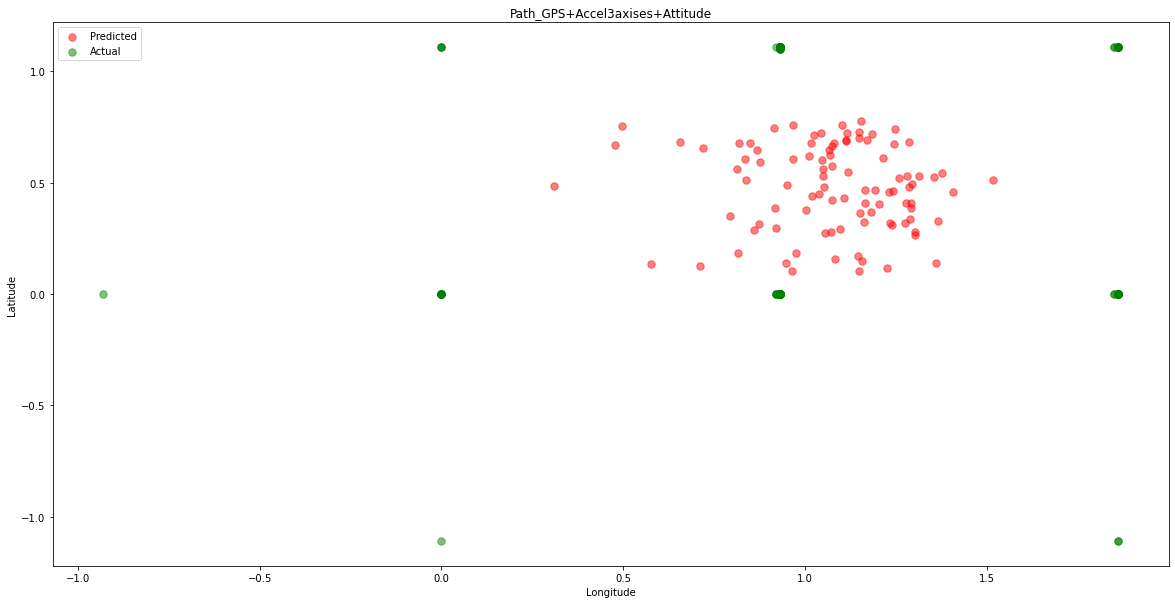

In [45]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array = np.array(y_pred1)
new_y1_data_array = np.array(new_y_data)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat = y_preds_array.reshape(-1, y_preds_array.shape[-1])
new_y1_data_flat = new_y1_data_array.reshape(-1, new_y1_data_array.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_lat_lon = sc.inverse_transform(y_preds_flat)
rescaled_y_test_actual_lat_lon = sc.inverse_transform(new_y1_data_flat)

# 위도와 경도값만 가져오기
predicted_latitude = rescaled_y_preds_lat_lon[:, 0]
predicted_longitude = rescaled_y_preds_lat_lon[:, 1]

actual_latitude = rescaled_y_test_actual_lat_lon[:, 0]
actual_longitude = rescaled_y_test_actual_lat_lon[:, 1]

plt.figure(figsize=(20, 10))
plt.scatter(x=predicted_longitude, y=predicted_latitude, label='Predicted', c='r', s=55, alpha=0.5)
plt.scatter(x=actual_longitude, y=actual_latitude, label='Actual', c='g', s=55, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Path_GPS+Accel3axises+Attitude')
plt.legend()
plt.show()

No handles with labels found to put in legend.


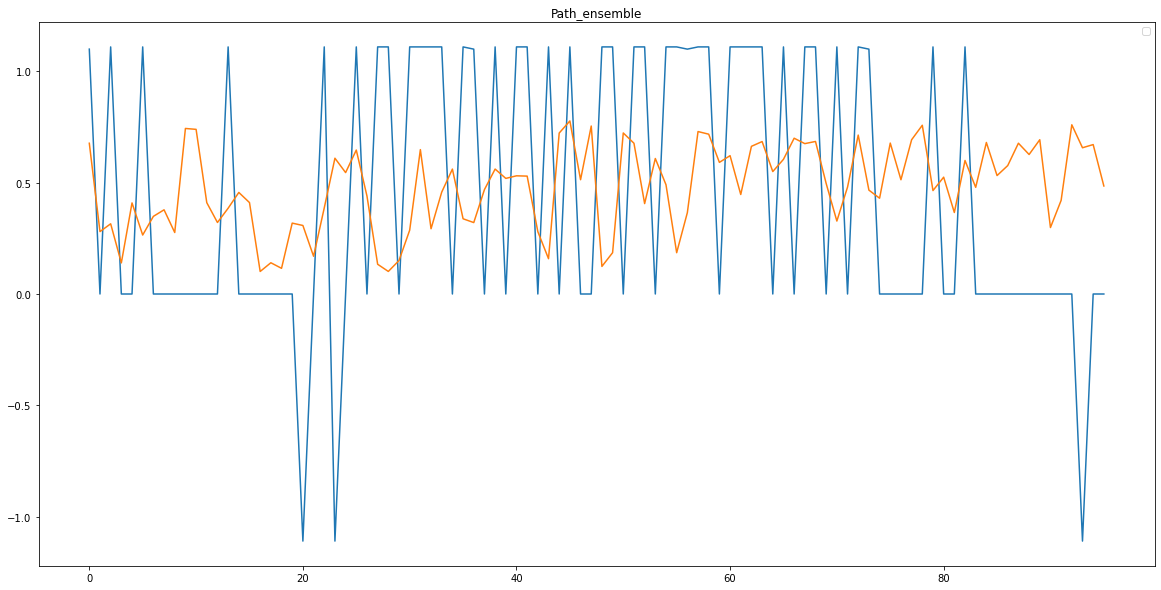

In [46]:
import numpy as np

y_preds_array = np.array(y_pred1)
new_y1_data_array = np.array(new_y_data)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat = y_preds_array.reshape(-1, y_preds_array.shape[-1])
new_y1_data_flat = new_y1_data_array.reshape(-1, new_y1_data_array.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_lat_lon = sc.inverse_transform(y_preds_flat)
rescaled_y_test_actual_lat_lon = sc.inverse_transform(new_y1_data_flat)

# 위도와 경도값만 가져오기
predicted_latitude = rescaled_y_preds_lat_lon[:, 0]
predicted_longitude = rescaled_y_preds_lat_lon[:, 1]

actual_latitude = rescaled_y_test_actual_lat_lon[:, 0]
actual_longitude = rescaled_y_test_actual_lat_lon[:, 1]

plt.figure(figsize=(20, 10))
plt.plot(actual_latitude)
plt.plot(predicted_latitude)
plt.title('Path_ensemble')
plt.legend()
plt.show()

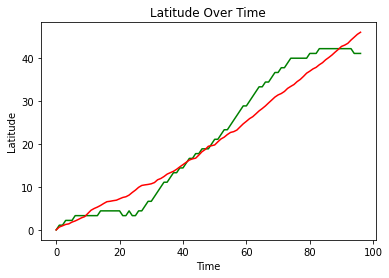

In [47]:
# 초기값 설정
initial_latitude = 0

# 실제 latitude 추정치 계산
Latitude_predicted = [initial_latitude]
for change in predicted_latitude:
    new_latitude = Latitude_predicted[-1] + change
    Latitude_predicted.append(new_latitude)

# 실제 latitude 추정치 계산
Latitude_actual = [initial_latitude]
for change in actual_latitude:
    new_latitude = Latitude_actual[-1] + change
    Latitude_actual.append(new_latitude) 
    
# 시각화
plt.plot(Latitude_actual, label='Actual', c='g')
plt.plot(Latitude_predicted, label='Predicted', c='r')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.title('Latitude Over Time')
plt.show()

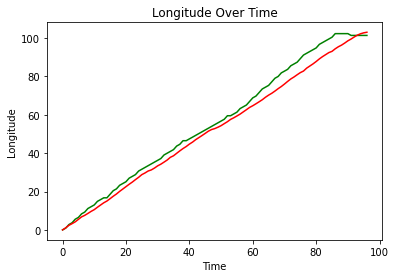

In [48]:
# 초기값 설정
initial_longitude = 0

# 실제 latitude 추정치 계산
Longitude_predicted = [initial_longitude]
for change in predicted_longitude:
    new_longitude = Longitude_predicted[-1] + change
    Longitude_predicted.append(new_longitude)

# 실제 latitude 추정치 계산
Longitude_actual = [initial_longitude]
for change in actual_longitude:
    new_longitude = Longitude_actual[-1] + change
    Longitude_actual.append(new_longitude) 
    
# 시각화
plt.plot(Longitude_actual, label='Actual', c='g')
plt.plot(Longitude_predicted, label='Predicted', c='r')
plt.xlabel('Time')
plt.ylabel('Longitude')
plt.title('Longitude Over Time')
plt.show()

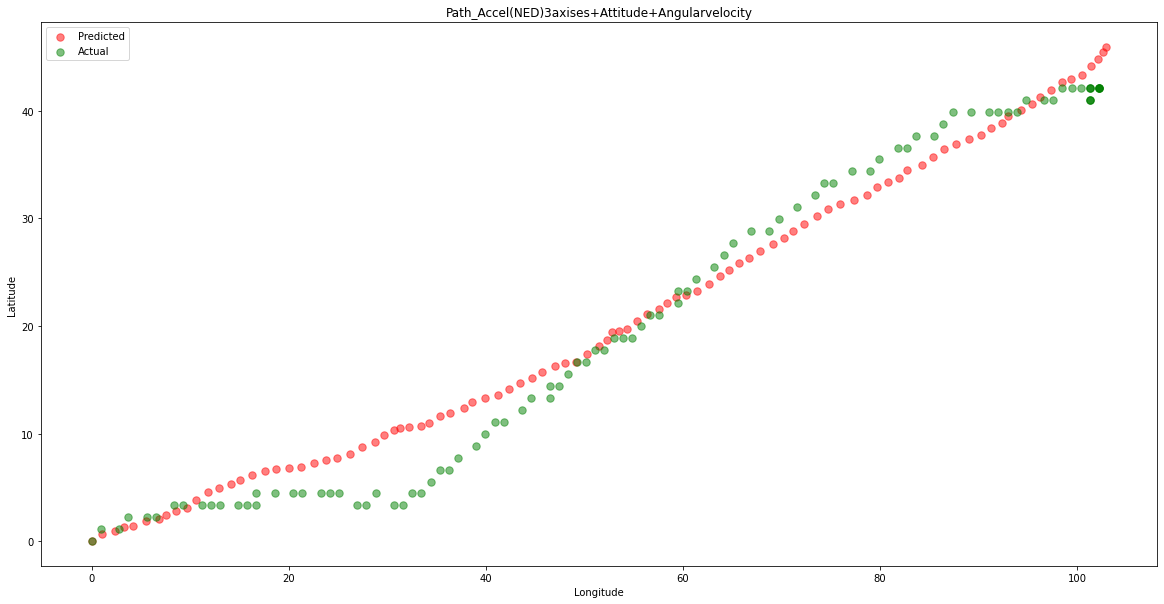

In [49]:
plt.figure(figsize=(20, 10))
plt.scatter(x=Longitude_predicted, y=Latitude_predicted, label='Predicted', c='r', s=55, alpha=0.5)
plt.scatter(x=Longitude_actual, y=Latitude_actual, label='Actual', c='g', s=55, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Path_Accel(NED)3axises+Attitude+Angularvelocity')
plt.legend()
plt.show()